<a href="https://colab.research.google.com/github/chengleniubi/L_tensor/blob/main/04.%E7%A5%9E%E7%BB%8F%E7%BD%91%E7%BB%9C%EF%BC%88%E8%BF%9B%E9%98%B6%EF%BC%89/4.deep-nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 深层神经网络

下面我们直接用 mnist 举例，讲一讲深度神经网络

In [1]:
import numpy as np
import torch
from torchvision.datasets import mnist # 导入 pytorch 内置的 mnist 数据

from torch import nn
from torch.autograd import Variable

In [2]:
# 使用内置函数下载 mnist 数据集
train_set = mnist.MNIST('./data', train=True, download=True)
test_set = mnist.MNIST('./data', train=False, download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/home/chengle/.local/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


我们可以看看其中的一个数据是什么样子的

In [3]:
a_data, a_label = train_set[0]

In [4]:
a_data

In [5]:
a_label

5

这里的读入的数据是 PIL 库中的格式，我们可以非常方便地将其转换为 numpy array

In [ ]:
a_data = np.array(a_data, dtype='float32')
print(a_data.shape)

这里我们可以看到这种图片的大小是 28 x 28

In [ ]:
print(a_data)

我们可以将数组展示出来，里面的 0 就表示黑色，255 表示白色

对于神经网络，我们第一层的输入就是 28 x 28 = 784，所以必须将得到的数据我们做一个变换，使用 reshape 将他们拉平成一个一维向量

In [8]:
def data_tf(x):
    x = np.array(x, dtype='float32') / 255
    x = (x - 0.5) / 0.5 # 标准化，这个技巧之后会讲到
    x = x.reshape((-1,)) # 拉平
    x = torch.from_numpy(x)
    return x

train_set = mnist.MNIST('./data', train=True, transform=data_tf, download=True) # 重新载入数据集，申明定义的数据变换
test_set = mnist.MNIST('./data', train=False, transform=data_tf, download=True)

In [9]:
a, a_label = train_set[0]
print(a.shape)
print(a_label)

torch.Size([784])
5


In [10]:
from torch.utils.data import DataLoader
# 使用 pytorch 自带的 DataLoader 定义一个数据迭代器
train_data = DataLoader(train_set, batch_size=64, shuffle=True)
test_data = DataLoader(test_set, batch_size=128, shuffle=False)

使用这样的数据迭代器是非常有必要的，如果数据量太大，就无法一次将他们全部读入内存，所以需要使用 python 迭代器，每次生成一个批次的数据

In [11]:
a, a_label = next(iter(train_data))

In [12]:
# 打印出一个批次的数据大小
print(a.shape)
print(a_label.shape)

torch.Size([64, 784])
torch.Size([64])


In [13]:
# 使用 Sequential 定义 4 层神经网络
net = nn.Sequential(
    nn.Linear(784, 400),
    nn.ReLU(),
    nn.Linear(400, 200),
    nn.ReLU(),
    nn.Linear(200, 100),
    nn.ReLU(),
    nn.Linear(100, 10)
)

In [ ]:
net

交叉熵在 pytorch 中已经内置了，交叉熵的数值稳定性更差，所以内置的函数已经帮我们解决了这个问题

In [42]:
# 定义 loss 函数
criterion = nn.CrossEntropyLoss()#交叉熵
optimizer = torch.optim.SGD(net.parameters(), 1e-1) # 使用随机梯度下降，学习率 0.1

In [43]:
# 开始训练
losses = []
acces = []
eval_losses = []
eval_acces = []

# aaaa=1
for e in range(20):
    train_loss = 0
    train_acc = 0
    net.train()   #在前向训练的过程中指定当前模型是训练还是在验证。
    for im, label in train_data:
        im = Variable(im)
        label = Variable(label)
        # 前向传播
        out = net(im) #输出out是一个概率组，十个输出的
        loss = criterion(out, label)
        # 反向传播
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 记录误差
        train_loss += loss.item()
        # 计算分类的准确率
        _, pred = out.max(1)
        # if aaaa:
        #   print(out)
        #   print(out.max(1))
        #   print(pred)
        #   print(label)
        #   aaaa=0
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        train_acc += acc
        
    losses.append(train_loss / len(train_data))
    acces.append(train_acc / len(train_data))
    # 在测试集上检验效果

    eval_loss = 0
    eval_acc = 0
    net.eval() # 将模型改为预测模式,对应net.train() 
    for im, label in test_data:
        im = Variable(im)
        label = Variable(label)
        out = net(im)
        loss = criterion(out, label)
        # 记录误差
        eval_loss += loss.item()
        # 记录准确率
        _, pred = out.max(1)
        num_correct = (pred == label).sum().item()
        acc = num_correct / im.shape[0]
        eval_acc += acc
        
    eval_losses.append(eval_loss / len(test_data))
    eval_acces.append(eval_acc / len(test_data))
    print('epoch: {}, Train Loss: {:.6f}, Train Acc: {:.6f}, Eval Loss: {:.6f}, Eval Acc: {:.6f}'
          .format(e, train_loss / len(train_data), train_acc / len(train_data), 
                     eval_loss / len(test_data), eval_acc / len(test_data)))

epoch: 0, Train Loss: 0.000255, Train Acc: 0.999933, Eval Loss: 0.076869, Eval Acc: 0.984672
epoch: 1, Train Loss: 0.000224, Train Acc: 0.999950, Eval Loss: 0.077232, Eval Acc: 0.984968
epoch: 2, Train Loss: 0.000160, Train Acc: 0.999983, Eval Loss: 0.076075, Eval Acc: 0.985463
epoch: 3, Train Loss: 0.000111, Train Acc: 1.000000, Eval Loss: 0.076203, Eval Acc: 0.985463
epoch: 4, Train Loss: 0.000092, Train Acc: 1.000000, Eval Loss: 0.076674, Eval Acc: 0.985562
epoch: 5, Train Loss: 0.000078, Train Acc: 1.000000, Eval Loss: 0.077283, Eval Acc: 0.985562
epoch: 6, Train Loss: 0.000073, Train Acc: 1.000000, Eval Loss: 0.078286, Eval Acc: 0.985562
epoch: 7, Train Loss: 0.000069, Train Acc: 1.000000, Eval Loss: 0.078520, Eval Acc: 0.985463
epoch: 8, Train Loss: 0.000065, Train Acc: 1.000000, Eval Loss: 0.078553, Eval Acc: 0.985265
epoch: 9, Train Loss: 0.000062, Train Acc: 1.000000, Eval Loss: 0.079037, Eval Acc: 0.985265
epoch: 10, Train Loss: 0.000058, Train Acc: 1.000000, Eval Loss: 0.079

画出 loss 曲线和 准确率曲线

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

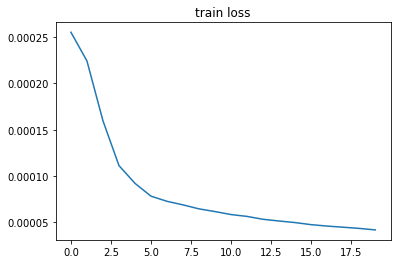

In [45]:
plt.title('train loss')
plt.plot(np.arange(len(losses)), losses)

Text(0.5, 1.0, 'train acc')

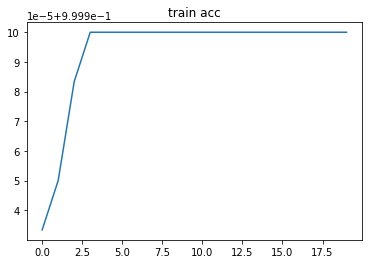

In [46]:
plt.plot(np.arange(len(acces)), acces)
plt.title('train acc')

Text(0.5, 1.0, 'test loss')

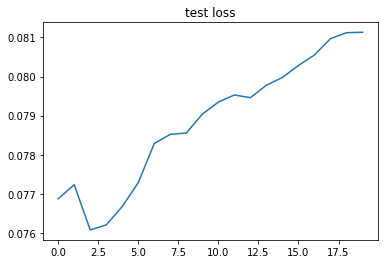

In [47]:
plt.plot(np.arange(len(eval_losses)), eval_losses)
plt.title('test loss')

Text(0.5, 1.0, 'test acc')

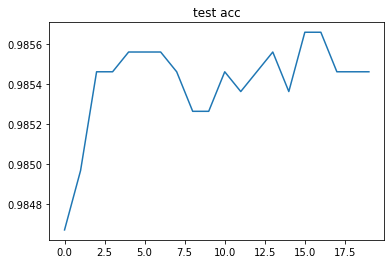

In [48]:
plt.plot(np.arange(len(eval_acces)), eval_acces)
plt.title('test acc')

可以看到我们的三层网络在训练集上能够达到 99.9% 的准确率，测试集上能够达到 98.20% 的准确率

**小练习：看一看上面的训练过程，看一下准确率是怎么计算出来的，特别注意 max 这个函数**

**自己重新实现一个新的网络，试试改变隐藏层的数目和激活函数，看看有什么新的结果**